In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)

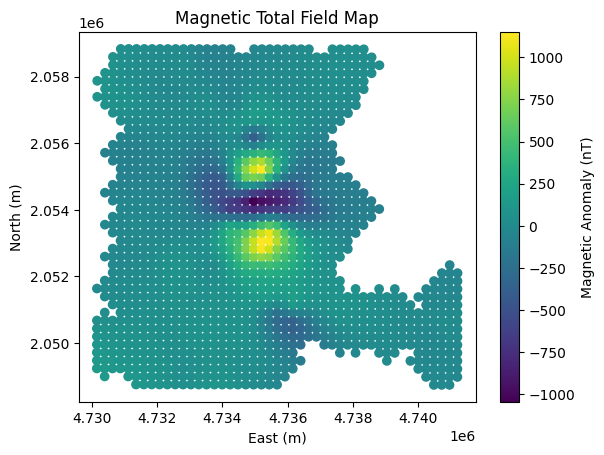

In [3]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [4]:
# Coordinates and values
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [5]:
# numpy matrix
coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

coords_magn_min = np.stack([np.min(x_magn), np.min(y_magn)], axis=0).astype(np.float32) 
coords_magn_max = np.stack([np.max(x_magn), np.max(y_magn)], axis=0).astype(np.float32)

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   


Xm_n = (coords_magn[:,0]-coords_magn_min[0])/(coords_magn_max[0]-coords_magn_min[0])
Ym_n = (coords_magn[:,1]-coords_magn_min[1])/(coords_magn_max[1]-coords_magn_min[1])


coords_magn_norm = np.stack([Xm_n, Ym_n], axis=1).astype(np.float32)

# DataLoaders
ds_magn = TensorDataset(torch.from_numpy(coords_magn_norm), torch.from_numpy(targets_magn))

dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [6]:
#Split dataloader
batch_size = 256
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
###### Training
iter = 10
activation = "relu"
input_transform = "FF"
num_layers = 15
num_neurons = 128

epochs = 5000

lr = 1e-4
max_lr = 2e-4

early_stopper = EarlyStoppingTrainLoss(patience=200, min_delta=0.0, restore_best=True)

save_every = max(1, epochs // 10)
saved_ckpts = 0
target_ckpts = 10

run_dir = os.path.join("checkpoints", f"Activation_{activation}_earlystop")
os.makedirs(run_dir, exist_ok=True)

In [ ]:
for i in range(iter+1):

    if activation == "wire":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "sine":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "relu":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, input_transform=input_transform  # synthetic-like defaults
        )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_magn),
        epochs=epochs
    )
    
    loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_magn in dl_magn_train:
            optimizer.zero_grad()
            coords_magn, target_magn = batch_magn
            pred_magn = model(coords_magn)
            pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

            loss = criterion(pred_magn_denorm,target_magn)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        train_loss = running_loss / max(1, len(dl_magn_train))

        if ((epoch + 1) % save_every == 0) and (saved_ckpts < target_ckpts):
            torch.save(model.state_dict(), os.path.join(run_dir, f"{1}magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth"))
            saved_ckpts += 1


        # early stopping basado en training loss
        early_stopper.step(train_loss, model)
        if early_stopper.early_stop:
            print(f"Early stopping en epoch {epoch+1}")
            break

        print("Iter: ", i," Epoch: ", epoch, " Loss: ", loss.item())

Iter:  2  Epoch:  817  Loss:  227.943115234375
Iter:  2  Epoch:  818  Loss:  285.6977844238281
Iter:  2  Epoch:  819  Loss:  198.03175354003906
Iter:  2  Epoch:  820  Loss:  214.87100219726562
Iter:  2  Epoch:  821  Loss:  181.26446533203125
Iter:  2  Epoch:  822  Loss:  134.61903381347656
Iter:  2  Epoch:  823  Loss:  145.35165405273438
Iter:  2  Epoch:  824  Loss:  198.26190185546875
Iter:  2  Epoch:  825  Loss:  251.23306274414062
Iter:  2  Epoch:  826  Loss:  173.13539123535156
Iter:  2  Epoch:  827  Loss:  154.54931640625
Iter:  2  Epoch:  828  Loss:  125.92176818847656
Iter:  2  Epoch:  829  Loss:  309.7066650390625
Iter:  2  Epoch:  830  Loss:  142.94924926757812
Iter:  2  Epoch:  831  Loss:  135.4389190673828
Iter:  2  Epoch:  832  Loss:  195.94082641601562
Iter:  2  Epoch:  833  Loss:  126.3689193725586
Iter:  2  Epoch:  834  Loss:  202.04722595214844
Iter:  2  Epoch:  835  Loss:  198.24130249023438
Iter:  2  Epoch:  836  Loss:  281.89794921875
Iter:  2  Epoch:  837  Loss:  13

In [ ]:
activation = "relu"

for i in range(iter+1):

    if activation == "wire":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "sine":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "relu":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, input_transform=input_transform  # synthetic-like defaults        
        )
    model.load_state_dict(torch.load(f"checkpoints/{i}magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()

    mse = []
    for batch_magn in dl_magn_val:
        coords_magn, target_magn = batch_magn

        pred_magn = model(coords_magn)
        pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

        #coords_magn_denorm = denorm_torch(coords_magn, coords_magn_min, coords_magn_max)

        #print("Coords: ", coords_magn_denorm[0], " Target: ", target_magn[2].item(), " Prediction: ", pred_magn_denorm[2].item())
        #print("MSE: ", criterion(pred_magn_denorm,target_magn).item())

        mse.append(criterion(pred_magn_denorm,target_magn).item())


print("MSE Mean: ", np.mean(mse))

MSE Mean:  792.0351867675781


In [ ]:
######  Metodo baseline - funciones de activacion

#### Relu
###MSE:  792.0351867675781

#### Sine
###MSE:  432.54088592529297

#### Wire
###MSE:  481.4898986816406